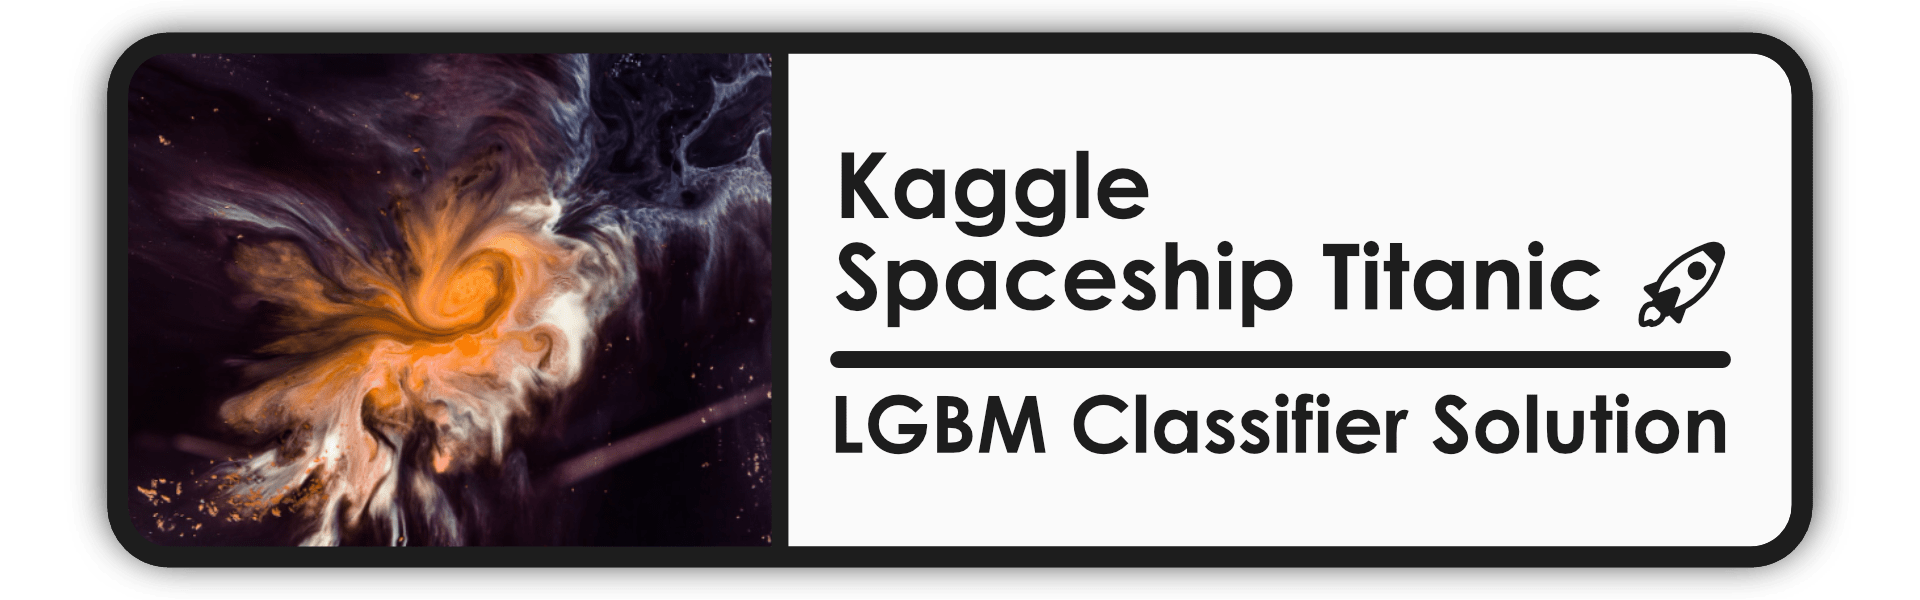
# **Introduction**

## **Context**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

## **Goal**

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

# **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier

import tqdm
import warnings
warnings.filterwarnings('ignore')

# **Data Loading and Preparation**

In [ ]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv')
test_df = pd.read_csv('../input/spaceship-titanic/test.csv')
submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

## File and Data Field Descriptions

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

**sample_submission.csv** - A submission file in the correct format.
- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.

## **Exploring Train Data**

In [ ]:
numeric_feature_names = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

categorical_feature_names = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "VIP"
]

In [ ]:
train_df.head()

In [ ]:
print('Number of rows in train_df: ', train_df.shape[0])
print('Number of columns in train_df: ', train_df.shape[1])
print('Number of values in train_df: ', train_df.count().sum())
print('Number of NaNs in train_df: ', sum(train_df.isna().sum()))
print('Number of NaNs in train_df in all columns:\n')
print(train_df.isna().sum())

In [ ]:
train_df.describe()

In [ ]:
train_df.dtypes

## **Exploring Test Data**

In [ ]:
test_df.head()

In [ ]:
print('Number of rows in test_df: ', test_df.shape[0])
print('Number of columns in test_df: ', test_df.shape[1])
print('Number of values in test_df: ', test_df.count().sum())
print('Number of NaNs in test_df: ', sum(test_df.isna().sum()))
print('Number of NaNs in test_df in all columns:\n')
print(test_df.isna().sum())

In [ ]:
test_df.describe()

In [ ]:
test_df.dtypes

## **Quick View of Submission File**

In [ ]:
submission_df.head()

In [ ]:
submission_df.describe()

# **EDA**

## **Target Variable Distribution**

In [ ]:
plt.figure(figsize = (20, 5))
sns.countplot(y = train_df['Transported'], color = '#b6d7a8')
plt.title("Target Distribution")
plt.show()

## **Numerical Feature Distribution**

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(25, 15))
for i, feature in enumerate(numeric_feature_names):
    sns.distplot(train_df[feature], color = '#b6d7a8', ax=ax[math.floor(i/2), i%2])
fig.show()

## **Categorical Feature Distribution**

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(25, 15))
for i, feature in enumerate(categorical_feature_names):
    sns.countplot(train_df[feature], color = '#b6d7a8', ax=ax[math.floor(i/2), i%2])
fig.show()

## **Correlation of Features**

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=train_df.corr(), annot=True, cmap = "Greens")

# **Preprocessing**

In [ ]:
train_df.drop(['VIP'], axis=1, inplace=True)
test_df.drop(['VIP'], axis=1, inplace=True)

In [ ]:
train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)
train_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['Cabin'], axis=1, inplace=True)

In [ ]:
expenditure_train = []
expenditure_test = []

for i in range(len(train_df)):
    expenditure_train.append(train_df['RoomService'][i] +
                             train_df['FoodCourt'][i] +
                             train_df['ShoppingMall'][i] +
                             train_df['Spa'][i] +
                             train_df['VRDeck'][i])

for i in range(len(test_df)):
    expenditure_test.append(test_df['RoomService'][i] +
                            train_df['FoodCourt'][i] +
                            test_df['ShoppingMall'][i] +
                            test_df['Spa'][i] +
                            test_df['VRDeck'][i])

In [ ]:
train_df['Expanditure'] = expenditure_train
test_df['Expanditure'] = expenditure_test

In [ ]:
no_spending_train = []
no_spending_test = []

for i in range(len(train_df)):
    if expenditure_train[i] == 0:
        no_spending_train.append(1)
    else:
        no_spending_train.append(0)

for i in range(len(test_df)):
    if expenditure_test[i] == 0:
        no_spending_test.append(1)
    else:
        no_spending_test.append(0)

In [ ]:
train_df["NoSpending"] = no_spending_train
test_df["NoSpending"] = no_spending_test

In [ ]:
age_18_train = []
age_18_test = []
age_18_25_train = []
age_18_25_test = []
age_25_plus_train = []
age_25_plus_test = []

In [ ]:
# train 1-18
for i in range(len(train_df)):
    age = train_df['Age'][i]
    if age <= 18:
        age_18_train.append(1)
    else:
        age_18_train.append(0)

# train 18-25
for i in range(len(train_df)):
    age = train_df['Age'][i]
    if (age > 18) and (age <= 25):
        age_18_25_train.append(1)
    else:
        age_18_25_train.append(0)

# train 25+
for i in range(len(train_df)):
    age = train_df['Age'][i]
    if age > 25:
        age_25_plus_train.append(1)
    else:
        age_25_plus_train.append(0)
train_df['Age<18'] = age_18_train
train_df['Age18-25'] = age_18_25_train
train_df['Age25<'] = age_25_plus_train

In [ ]:
# test 1-18
for i in range(len(test_df)):
    age = test_df['Age'][i]
    if age <= 18:
        age_18_test.append(1)
    else:
        age_18_test.append(0)

# test 18-25
for i in range(len(test_df)):
    age = test_df['Age'][i]
    if (age > 18) and (age <= 25):
        age_18_25_test.append(1)
    else:
        age_18_25_test.append(0)

# test 25+
for i in range(len(test_df)):
    age = test_df['Age'][i]
    if age > 25:
        age_25_plus_test.append(1)
    else:
        age_25_plus_test.append(0)

test_df['Age<18'] = age_18_test
test_df['Age18-25'] = age_18_25_test
test_df['Age25<'] = age_25_plus_test

In [ ]:
label_cols = ["HomePlanet", "CryoSleep", "Destination", "Deck", "Num", "Side"]

def label_encoder(train_df, test_df, columns):
    for col in columns:
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        train_df[col] = LabelEncoder().fit_transform(train_df[col])
        test_df[col] =  LabelEncoder().fit_transform(test_df[col])
    return train_df, test_df

train_df, test_df = label_encoder(train_df, test_df ,label_cols)

In [ ]:
train_df.drop(['Name'], inplace=True, axis=1)
test_df.drop(['Name'], inplace=True, axis=1)

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
X = train_df.drop('Transported', axis =1 )
Y = train_df['Transported']
train_df.drop("PassengerId", inplace=True, axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 12, test_size =0.33)

# **Modeling**

In [ ]:
lgb_params = {
    'objective' : 'binary',
    'n_estimators' : 50,
    'learning_rate' : 0.9
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
features = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Num', 'Side', 'Expanditure', 'NoSpending', 'Age<18', 'Age18-25', 'Age25<']

skf = StratifiedKFold(n_splits=100, shuffle=True, random_state=12)
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(train_df[features], train_df['Transported']))):
    X_train, X_valid = train_df.iloc[train_idx][features], train_df.iloc[valid_idx][features]
    Y_train, Y_valid = train_df['Transported'].iloc[train_idx], train_df['Transported'].iloc[valid_idx]

    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, Y_train,verbose=0)

    preds_valid = model.predict(X_valid)
    acc = accuracy_score(Y_valid,  preds_valid)
    lgb_scores.append(acc)

    fim = pd.DataFrame(index=features, data=model.feature_importances_, columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)

    test_preds = model.predict(test_df[features])
    lgb_predictions += test_preds/5

print("Mean Accuracy :", np.mean(lgb_scores))

# **Submission**

In [ ]:
submission_df['Transported'] = lgb_predictions.astype("bool")
submission_df.to_csv("submission.csv",index=False)

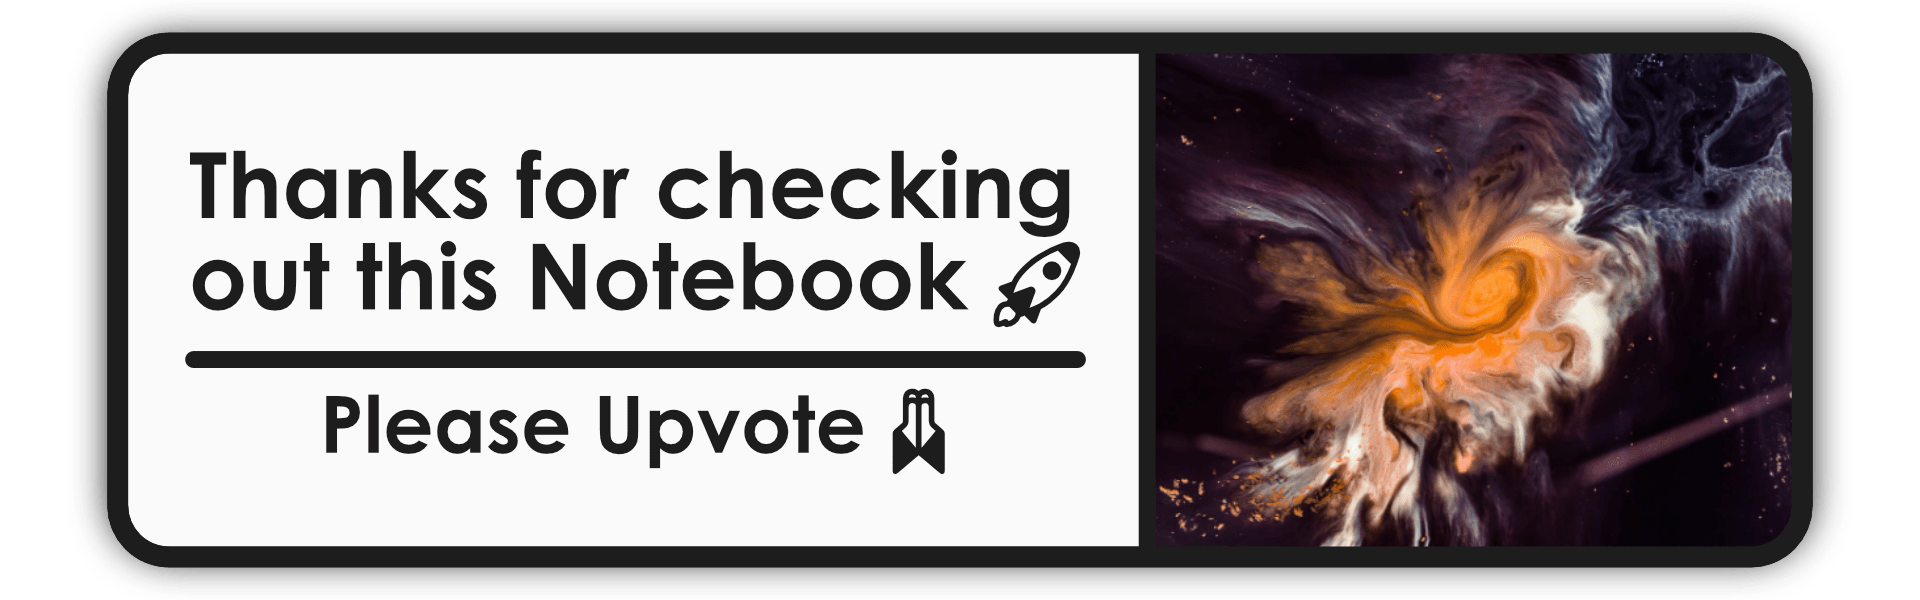

Special Thanks to people I was inspired by: **@usharengaraju (Tensor Girl)** and **@odins0n (Sanskar Hasija)** for creating their works on This Competition <3

Also, I am kind of begginer, so if you have any suggestions about the code - write them down in the disscusion section
